Written by Oguzhan Gur.

In [1]:
import numpy as np
from models.mobilenet import MobileFaceNet
from models.uncertainty_head import UncertaintyHead
import torch
from torchvision import transforms as trans
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import pair_MLS_score

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
device = torch.device("cpu")

In [3]:
# Load MobileFaceNet model
model = MobileFaceNet(512).to(device)
save_path = '/home/oguz/workspace/projects/arcface-pfe-torch/pretrained/model_mobilefacenet.pth'
model.load_state_dict(torch.load(save_path))

# Load UncertainityHead of PFE
pfe_model = UncertaintyHead()
checkpoint = torch.load('/home/oguz/workspace/projects/arcface-pfe-torch/checkpoints/pfe/sota.pth.tar')
pfe_model.load_state_dict(checkpoint['uncertain'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [4]:
# Transformation of image is important for getting accurate embeddings
test_transform = trans.Compose([
                    trans.ToTensor(),
                    trans.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                ])

In [5]:
# Inference functions for both MobileFaceNet and PFE
def infer_mobilefacenet(img, model, device):
    model.eval()
    embedding = model(test_transform(img).to(device).unsqueeze(0))[0]
    embedding = embedding.detach().numpy()
    conv_final = model(test_transform(img).to(device).unsqueeze(0))[1]
    return embedding, conv_final

def infer_pfe(conv_final, model, device):
    model.eval()
    sig_sq = torch.exp(pfe_model(conv_final.to(device)))
    sig_sq = sig_sq.detach().numpy()
    return sig_sq

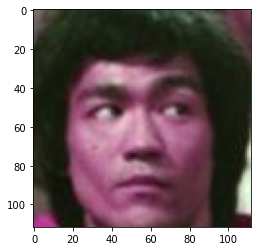

In [6]:
img_1 = Image.open('test_1.jpg')
plt.imshow(img_1)
embedding_1, conv_final_1 = infer_mobilefacenet(img_1,model,device)
sig_sq_1 = infer_pfe(conv_final_1, pfe_model, device)

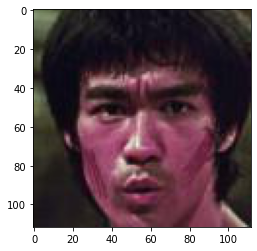

In [7]:
img_2 = Image.open('test_2.jpg')
plt.imshow(img_2)
embedding_2, conv_final_2 = infer_mobilefacenet(img_2,model,device)
sig_sq_2 = infer_pfe(conv_final_2, pfe_model, device)

In [8]:
# MobileFaceNet distance calculation:
threshold = 1.6 # example threshold value

diff = np.subtract(embedding_1, embedding_2)
dist = np.sum(np.square(diff), 1)

if dist > threshold:
    print('Two images belongs to different persons')
else:
    print('Two images belongs to same person')

Two images belongs to same person


In [9]:
#PFE distance calculation
threshold = -2350 # example threshold value

if pair_MLS_score(embedding_1,embedding_2,sig_sq_1,sig_sq_2) > -2350:
    print('Two images belongs to different persons')
else:
    print('Two images belongs to same person')

Two images belongs to same person
